In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from math import sqrt
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from pandas_datareader import data as pdr
import seaborn as sns

In [61]:
def get_ticker_data(ticker_code: str, start_date=None, end_date=datetime.today()):
    if start_date is not None:
        data = pdr.get_data_yahoo(ticker_code, start=start_date, end=end_date)
    else:
        data = pdr.get_data_yahoo(ticker_code, end=end_date)
    return data


def clean_ticker_data(df):
    df = df.reset_index()
    df.columns = [col.lower().replace(" ", "_") for col in df.columns]
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values(by="date", ascending=True)
    df.rename(columns={"date": "datetime"}, inplace=True)
    return df


def resample(df):
    df = df.set_index("datetime")
    df = df.resample("D").asfreq()
    return df


def basic_preprocess(df):
    df = df.astype("float64")
    df = df.interpolate(method="time")
    df = df.fillna("bfill")
    return df.reset_index()


def prepare_ticker_data(ticker_code: str, start_date=None, end_date=datetime.today()):
    df = get_ticker_data(ticker_code, start_date=start_date, end_date=end_date)
    df = clean_ticker_data(df)
    df = resample(df)
    df = basic_preprocess(df)
    return df

In [62]:
def get_ticker_data(ticker_code: str, start_date=None, end_date=datetime.today()):
    # Downloading stock data using yfinance
    if start_date is not None:
        data = yf.download(ticker_code, start=start_date, end=end_date)
    else:
        data = yf.download(ticker_code, end=end_date)
    return data

def clean_ticker_data(df):
    df = df.reset_index()
    df.columns = [col.lower().replace(" ", "_") for col in df.columns]
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values(by="date", ascending=True)
    df.rename(columns={"date": "datetime"}, inplace=True)
    return df

def resample(df):
    df = df.set_index("datetime")
    df = df.resample("D").asfreq()
    return df

def basic_preprocess(df):
    df = df.astype("float64")
    df = df.interpolate(method="time")
    df = df.fillna("bfill")
    return df.reset_index()

def prepare_ticker_data(ticker_code: str, start_date=None, end_date=datetime.today()):
    df = get_ticker_data(ticker_code, start_date=start_date, end_date=end_date)
    df = clean_ticker_data(df)
    df = resample(df)
    df = basic_preprocess(df)
    return df

In [63]:
stock_data = prepare_ticker_data("AAPL", start_date="2004-06-01")
stock_data.to_csv("AAPL_daily.csv", index=False)

[*********************100%***********************]  1 of 1 completed


In [64]:
aapl_daily = pd.read_csv("AAPL_daily.csv")
aapl_daily

,datetime,open,high,low,close,adj_close,volume
0,2004-06-01,0.496250,0.503571,0.493036,0.501071,0.423142,182134400.0
1,2004-06-02,0.500536,0.520893,0.496429,0.516429,0.436112,318712800.0
2,2004-06-03,0.512857,0.517679,0.505179,0.507143,0.428270,250930400.0
3,2004-06-04,0.510000,0.522321,0.509107,0.513929,0.434000,399112000.0
4,2004-06-05,0.512857,0.526666,0.510893,0.520060,0.439178,364700000.0
...,...,...,...,...,...,...,...
7412,2024-09-16,216.539993,217.220001,213.919998,216.320007,216.320007,59357400.0
7413,2024-09-17,215.750000,216.899994,214.500000,216.789993,216.789993,45519300.0
7414,2024-09-18,217.550003,222.710007,217.539993,220.690002,220.690002,59894900.0
7415,2024-09-19,224.990005,229.820007,224.630005,228.869995,228.869995,66781300.0


In [65]:
#DATA PREPROCESSING

In [66]:
# Calculate MACD
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    exp1 = df["close"].ewm(span=short_window, adjust=False).mean()
    exp2 = df["close"].ewm(span=long_window, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    df["macd"] = macd
    df["macd_signal"] = signal
    return df

# Calculate RSI
def calculate_rsi(df, window=14):
    delta = df["close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df["rsi"] = 100 - (100 / (1 + rs))
    return df

# Function to find crossover points and label them as "Buy" or "Sell"
def find_crossover_points(df):
    crossover_points = []
    prev_crossover = None

    for i in range(1, len(df)):
        if df["macd"][i] > df["macd_signal"][i] and df["macd"][i - 1] <= df["macd_signal"][i - 1]:
            crossover_points.append(("Buy", df["datetime"][i]))
            prev_crossover = "Buy"
        elif df["macd"][i] < df["macd_signal"][i] and df["macd"][i - 1] >= df["macd_signal"][i - 1]:
            crossover_points.append(("Sell", df["datetime"][i]))
            prev_crossover = "Sell"
        else:
            if prev_crossover is not None:
                crossover_points.append((prev_crossover, df["datetime"][i]))

    return crossover_points


def find_crossover_points_mod(df):
    crossover_points = ["No Action"]
    prev_crossover = None

    for i in range(1, len(df)):
        if (df["macd"][i] > df["macd_signal"][i] and df["macd"][i - 1] <= df["macd_signal"][i - 1]) or \
           (df["macd"][i] < df["macd_signal"][i] and df["macd"][i - 1] >= df["macd_signal"][i - 1]):
            crossover_points.append("Buy" if df["macd"][i] > df["macd_signal"][i] else "Sell")
            prev_crossover = "Buy" if df["macd"][i] > df["macd_signal"][i] else "Sell"
        else:
            if prev_crossover is not None:
                crossover_points.append(prev_crossover)
            else:
                crossover_points.append("No Action")

    return crossover_points

In [67]:
df = pd.read_csv(
    "AAPL_daily.csv",
    usecols=["datetime", "close"]
)
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df["day_of_week"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year
df["day_of_year"] = df["datetime"].dt.dayofyear
df["quarter"] = df["datetime"].dt.quarter

df = calculate_macd(df, short_window=12, long_window=26, signal_window=10)
df = calculate_rsi(df)
df.dropna(inplace=True)

df

,datetime,close,day_of_week,month,year,day_of_year,quarter,macd,macd_signal,rsi
13,2004-06-14,0.537857,0,6,2004,166,2,0.010940,0.008615,72.198256
14,2004-06-15,0.548036,1,6,2004,167,2,0.011299,0.009103,75.239990
15,2004-06-16,0.584643,2,6,2004,168,2,0.014372,0.010061,79.843580
16,2004-06-17,0.585893,3,6,2004,169,2,0.016716,0.011271,87.058848
17,2004-06-18,0.587679,4,6,2004,170,2,0.018504,0.012586,86.419787
...,...,...,...,...,...,...,...,...,...,...
7412,2024-09-16,216.320007,0,9,2024,260,3,-1.215482,-0.457280,25.833713
7413,2024-09-17,216.789993,1,9,2024,261,3,-1.443587,-0.636609,30.684695
7414,2024-09-18,220.690002,2,9,2024,262,3,-1.294738,-0.756269,49.541799
7415,2024-09-19,228.869995,3,9,2024,263,3,-0.510829,-0.711643,63.459134


In [68]:
features_to_be_scaled = ["day_of_week", "month", "year", "day_of_year", "quarter", "macd", "macd_signal", "rsi"]
predicate_scaler = ["close"]

In [69]:

# Feature scaler
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(df[features_to_be_scaled])
df[[f"scaled_{i}" for i in features_to_be_scaled]] = scaled_features

# Prediction scaler
prediction_scaler = MinMaxScaler()
scaled_predictions = prediction_scaler.fit_transform(df[predicate_scaler])
df[[f"scaled_{i}" for i in predicate_scaler]] = scaled_predictions

df

,datetime,close,day_of_week,month,year,day_of_year,quarter,macd,macd_signal,rsi,scaled_day_of_week,scaled_month,scaled_year,scaled_day_of_year,scaled_quarter,scaled_macd,scaled_macd_signal,scaled_rsi,scaled_close
13,2004-06-14,0.537857,0,6,2004,166,2,0.010940,0.008615,72.198256,0.000000,0.454545,0.0,0.452055,0.333333,0.448462,0.447324,0.718486,0.000075
14,2004-06-15,0.548036,1,6,2004,167,2,0.011299,0.009103,75.239990,0.166667,0.454545,0.0,0.454795,0.333333,0.448490,0.447367,0.749286,0.000118
15,2004-06-16,0.584643,2,6,2004,168,2,0.014372,0.010061,79.843580,0.333333,0.454545,0.0,0.457534,0.333333,0.448726,0.447450,0.795900,0.000274
16,2004-06-17,0.585893,3,6,2004,169,2,0.016716,0.011271,87.058848,0.500000,0.454545,0.0,0.460274,0.333333,0.448906,0.447556,0.868961,0.000280
17,2004-06-18,0.587679,4,6,2004,170,2,0.018504,0.012586,86.419787,0.666667,0.454545,0.0,0.463014,0.333333,0.449044,0.447671,0.862490,0.000287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,2024-09-16,216.320007,0,9,2024,260,3,-1.215482,-0.457280,25.833713,0.000000,0.727273,1.0,0.709589,0.666667,0.354219,0.406642,0.249008,0.921041
7413,2024-09-17,216.789993,1,9,2024,261,3,-1.443587,-0.636609,30.684695,0.166667,0.727273,1.0,0.712329,0.666667,0.336690,0.390982,0.298128,0.923047
7414,2024-09-18,220.690002,2,9,2024,262,3,-1.294738,-0.756269,49.541799,0.333333,0.727273,1.0,0.715068,0.666667,0.348128,0.380534,0.489071,0.939693
7415,2024-09-19,228.869995,3,9,2024,263,3,-0.510829,-0.711643,63.459134,0.500000,0.727273,1.0,0.717808,0.666667,0.408367,0.384430,0.629995,0.974605


In [70]:

# Select a subset of data for plotting (for example, first 100 data points)
subset_df = df.tail(500).reset_index()
subset_df.drop(columns=["index"], inplace=True)

subset_df

,datetime,close,day_of_week,month,year,day_of_year,quarter,macd,macd_signal,rsi,scaled_day_of_week,scaled_month,scaled_year,scaled_day_of_year,scaled_quarter,scaled_macd,scaled_macd_signal,scaled_rsi,scaled_close
0,2023-05-10,173.559998,2,5,2023,130,2,2.440941,2.119274,73.135032,0.333333,0.363636,0.95,0.353425,0.333333,0.635195,0.631629,0.727971,0.738540
1,2023-05-11,173.750000,3,5,2023,131,2,2.478042,2.184505,65.968887,0.500000,0.363636,0.95,0.356164,0.333333,0.638046,0.637325,0.655408,0.739351
2,2023-05-12,172.570007,4,5,2023,132,2,2.384740,2.220911,58.689158,0.666667,0.363636,0.95,0.358904,0.333333,0.630876,0.640504,0.581695,0.734315
3,2023-05-13,172.403341,5,5,2023,133,2,2.271168,2.230049,58.210773,0.833333,0.363636,0.95,0.361644,0.333333,0.622148,0.641302,0.576851,0.733603
4,2023-05-14,172.236674,6,5,2023,134,2,2.143009,2.214223,57.740123,1.000000,0.363636,0.95,0.364384,0.333333,0.612300,0.639920,0.572086,0.732892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2024-09-16,216.320007,0,9,2024,260,3,-1.215482,-0.457280,25.833713,0.000000,0.727273,1.00,0.709589,0.666667,0.354219,0.406642,0.249008,0.921041
496,2024-09-17,216.789993,1,9,2024,261,3,-1.443587,-0.636609,30.684695,0.166667,0.727273,1.00,0.712329,0.666667,0.336690,0.390982,0.298128,0.923047
497,2024-09-18,220.690002,2,9,2024,262,3,-1.294738,-0.756269,49.541799,0.333333,0.727273,1.00,0.715068,0.666667,0.348128,0.380534,0.489071,0.939693
498,2024-09-19,228.869995,3,9,2024,263,3,-0.510829,-0.711643,63.459134,0.500000,0.727273,1.00,0.717808,0.666667,0.408367,0.384430,0.629995,0.974605


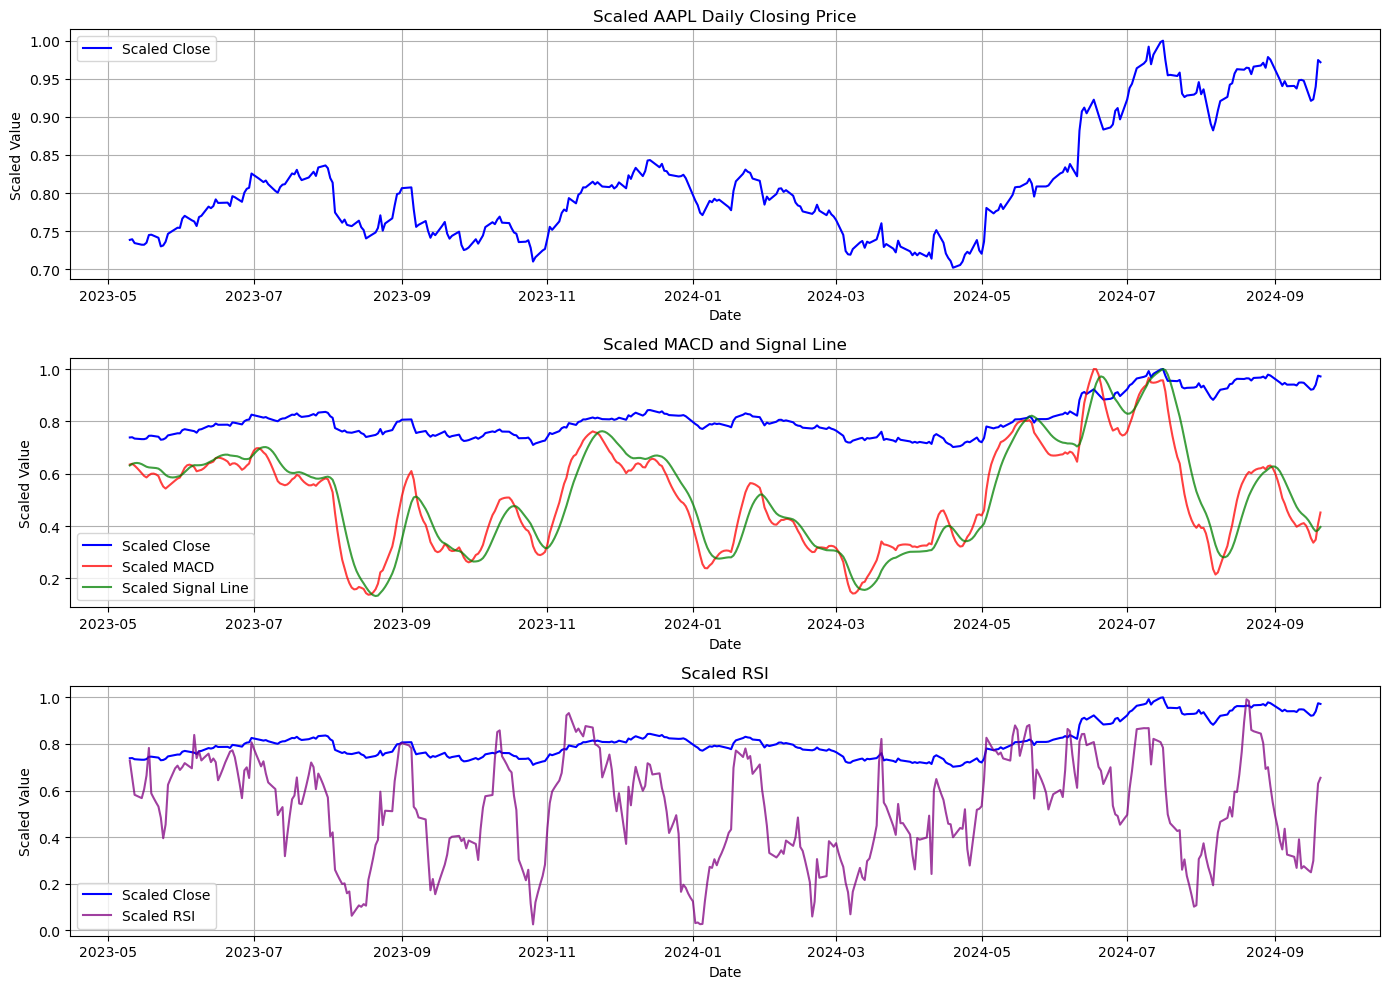

In [71]:
# Plotting
plt.figure(figsize=(14, 10))

# Closing price subplot
plt.subplot(3, 1, 1)
plt.plot(subset_df["datetime"], subset_df["scaled_close"], label="Scaled Close", color="blue")
plt.title("Scaled AAPL Daily Closing Price")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)

# MACD subplot
plt.subplot(3, 1, 2)
plt.plot(subset_df["datetime"], subset_df["scaled_close"], label="Scaled Close", color="blue")
plt.plot(subset_df["datetime"], subset_df["scaled_macd"], label="Scaled MACD", color="red", alpha=0.75)
plt.plot(subset_df["datetime"], subset_df["scaled_macd_signal"], label="Scaled Signal Line", color="green", alpha=0.75)
plt.title("Scaled MACD and Signal Line")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)

# RSI subplot
plt.subplot(3, 1, 3)
plt.plot(subset_df["datetime"], subset_df["scaled_close"], label="Scaled Close", color="blue")
plt.plot(subset_df["datetime"], subset_df["scaled_rsi"], label="Scaled RSI", color="purple", alpha=0.75)
plt.title("Scaled RSI")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Correlation Analysis
Based on the correlation matrix and your specific objectives, you might consider the following features:

Close Price (close): This is the target variable you want to predict. It has moderate correlations with year and macd_signal, indicating their potential predictive power.

MACD and MACD Signal (macd, macd_signal): These technical indicators have moderate correlations with the close price, suggesting they might be useful predictors. Additionally, they show a strong correlation with each other, which can be helpful for feature engineering or model selection.

Year (year): The year has a moderate correlation with the close price, indicating a potential trend over time. Including this feature might capture long-term trends in the stock price.

RSI (rsi): The Relative Strength Index has a weak positive correlation with the close price and moderate correlations with MACD and MACD Signal. While its correlation is weaker compared to other features, it might still provide valuable information for prediction.

Day of Week (day_of_week) and Month (month): These date-related features have very weak correlations with the close price. However, they might still capture seasonal patterns or behavioral trends in trading, so it could be worth experimenting with them.

You may start with these features and iteratively refine your model based on performance metrics such as accuracy, precision, recall, or Mean Squared Error (MSE). Additionally, consider incorporating domain knowledge or experimenting with feature engineering techniques to further improve predictive performance.

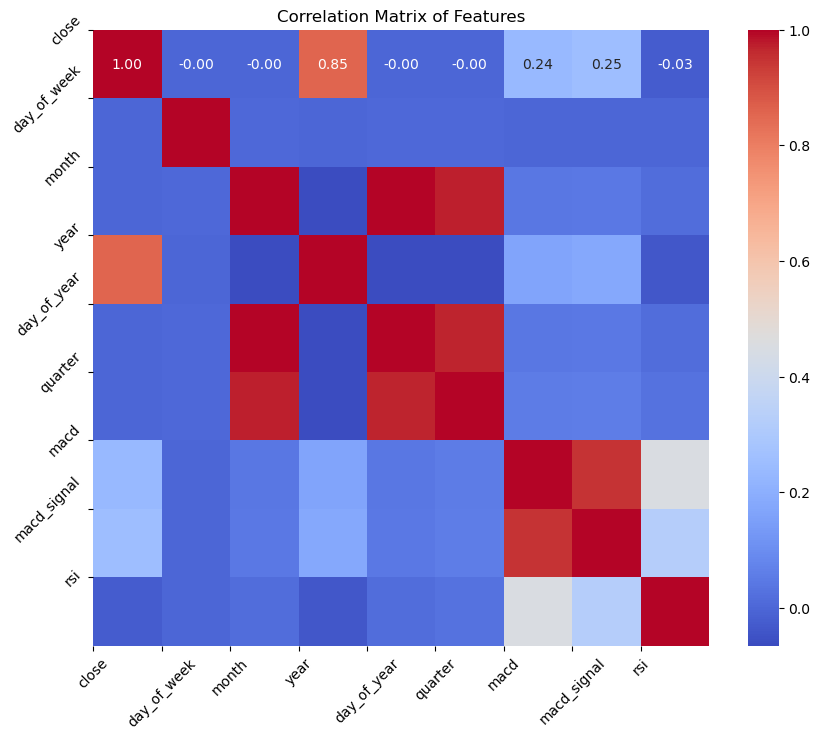

In [72]:
# Correlation analysis
correlation_matrix = df[["close", "day_of_week", "month", "year", "day_of_year", "quarter", "macd", "macd_signal", "rsi"]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title('Correlation Matrix of Features')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.show()

In [ ]:
#LSTM MODEL STARTS

In [2]:
tickers = ['AAPL']  # You can use multiple tickers
data = yf.download(tickers, start='2014-01-01', end='2024-09-20')
data = data[['Close']]  # Use only the 'Close' price

[*********************100%***********************]  1 of 1 completed


In [3]:
data.tail(20)

,Close
Date,
2024-08-22,224.529999
2024-08-23,226.839996
2024-08-26,227.179993
2024-08-27,228.029999
2024-08-28,226.490005
2024-08-29,229.789993
2024-08-30,229.000000
2024-09-03,222.770004
2024-09-04,220.850006


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2697 entries, 2014-01-02 to 2024-09-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2697 non-null   float64
dtypes: float64(1)
memory usage: 42.1 KB


In [5]:
data.describe()

,Close
count,2697.000000
mean,85.867417
std,62.104108
min,17.849285
25%,31.127501
50%,52.107498
75%,146.350006
max,234.820007


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM model
def prepare_data(data, time_step):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [7]:
time_step = 100
X, y = prepare_data(scaled_data, time_step)

In [8]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [12]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
print(test_size)

780


In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Model summary
model.summary()

# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),callbacks=[early_stopping, reduce_lr])

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0119 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 4.8055e-04 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 2.6475e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 2.5488e-04 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 2.2873e-04 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 2.4250e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 2.2824e-04 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 2.2164e-04 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 2.1854e-04 - val_loss: 0.0023 - 

In [76]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [77]:
# Calculate RMSE on scaled data (before inverse transforming)
train_rmse_scaled = sqrt(mean_squared_error(y_train, train_predict))
test_rmse_scaled = sqrt(mean_squared_error(y_test, test_predict))

print(f"Train RMSE (scaled): {train_rmse_scaled}")
print(f"Test RMSE (scaled): {test_rmse_scaled}")

Train RMSE (scaled): 0.01327161946254221
Test RMSE (scaled): 0.03350361444257377


In [78]:
# Inverse transform predictions and actual values for plotting and comparison
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# RMSE on original (inverse-transformed) data - for reference
train_rmse_original = sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse_original = sqrt(mean_squared_error(y_test_actual, test_predict))

print(f"Train RMSE (original): {train_rmse_original}")
print(f"Test RMSE (original): {test_rmse_original}")
print(train_predict.shape)
print(len(test_predict))

Train RMSE (original): 2.8795527387612903
Test RMSE (original): 7.2693043444127365
(1817, 1)
780


Train Predict Range Length: 1817
Train Actual Length: 1817
Test Predict Range Length: 780
Test Actual Length: 780


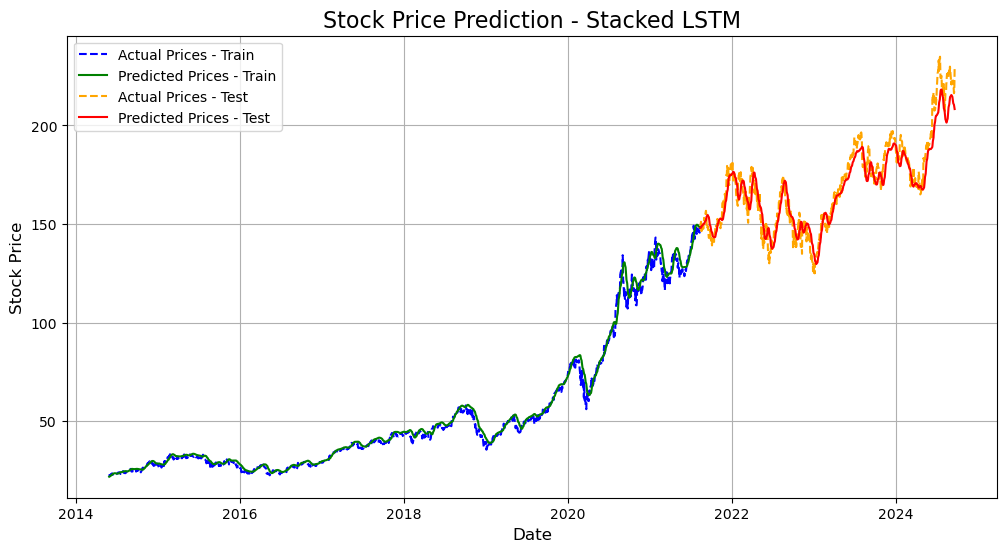

In [79]:
import matplotlib.pyplot as plt

def plot_stock_predictions(train_actual, train_predict, test_actual, test_predict, data, time_step, train_size):
    """
    Plots the actual vs predicted stock prices for both training and testing data.
    
    Parameters:
    - train_actual: Actual training data (inverse transformed).
    - train_predict: Predicted training data (inverse transformed).
    - test_actual: Actual testing data (inverse transformed).
    - test_predict: Predicted testing data (inverse transformed).
    - data: The original data (used for indexing the date range).
    - time_step: The time_step used for the LSTM model.
    - train_size: The size of the training dataset.
    """
    
    # Flatten the predicted values and actual values to ensure they are 1D arrays
    train_predict = train_predict.flatten()
    test_predict = test_predict.flatten()
    train_actual = train_actual.flatten()
    test_actual = test_actual.flatten()

    # Ensure actual and predicted data have the same length
    train_actual = train_actual[:len(train_predict)]
    test_actual = test_actual[:len(test_predict)]

    # Prepare the date ranges for plotting (same length as predictions)
    train_predict_range = data.index[time_step:time_step + len(train_predict)]
    test_predict_range = data.index[train_size + time_step:train_size + time_step + len(test_predict)]

    # Check the lengths to ensure they match
    print(f"Train Predict Range Length: {len(train_predict_range)}")
    print(f"Train Actual Length: {len(train_actual)}")
    print(f"Test Predict Range Length: {len(test_predict_range)}")
    print(f"Test Actual Length: {len(test_actual)}")

    # Plot actual vs predicted prices
    plt.figure(figsize=(12, 6))

    # Plot actual vs predicted for training data
    plt.plot(train_predict_range, train_actual, label='Actual Prices - Train', color='blue', linestyle='--')
    plt.plot(train_predict_range, train_predict, label='Predicted Prices - Train', color='green')

    # Plot actual vs predicted for testing data
    plt.plot(test_predict_range, test_actual, label='Actual Prices - Test', color='orange', linestyle='--')
    plt.plot(test_predict_range, test_predict, label='Predicted Prices - Test', color='red')

    # Adding titles and labels
    plt.title('Stock Price Prediction - Stacked LSTM', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    
    # Add grid and legend
    plt.grid(True)
    plt.legend()
    
    # Show the plot
    plt.show()

# Adjust the actual values to match predictions and flatten them if needed
train_actual_adjusted = y_train_actual.flatten()[:len(train_predict)]
test_actual_adjusted = y_test_actual.flatten()[:len(test_predict)]

# Call the plot function
plot_stock_predictions(
    train_actual=train_actual_adjusted,
    train_predict=train_predict,
    test_actual=test_actual_adjusted,
    test_predict=test_predict,
    data=data,
    time_step=time_step,
    train_size=train_size
)

In [80]:
class MockTradingEnvironment:
    def __init__(self, initial_investment, stock_data, predicted_prices, dates):
        self.initial_investment = initial_investment
        self.stock_data = stock_data  # The actual stock prices (y_test_actual)
        self.predicted_prices = predicted_prices  # The predicted stock prices (test_predict)
        self.cash = initial_investment  # Initial cash in portfolio
        self.shares_held = 0  # Number of shares currently held
        self.portfolio_value_history = []  # History of portfolio value over time
        self.shares_held_history = []  # Keep track of shares held after each trade
        self.buy_sell_signals = []  # Store buy/sell signals (1 for buy, -1 for sell, 0 for hold)
        self.transactions = []  # Store all transactions (date, action, shares, portfolio value)
        self.dates = dates[:len(predicted_prices)]  # Make sure dates align with the predictions

    def trade(self):
        for i in range(1, len(self.predicted_prices)):
            action = None  # To track if it's a buy/sell action in this step

            # If predicted price is going up and we have cash, buy
            if self.predicted_prices[i] > self.predicted_prices[i-1] and self.cash > 0:
                shares_to_buy = self.cash // self.stock_data[i]  # Buy as many shares as possible
                if shares_to_buy > 0:
                    self.cash -= shares_to_buy * self.stock_data[i]  # Deduct cash
                    self.shares_held += shares_to_buy  # Update the number of shares held
                    self.buy_sell_signals.append(1)  # Buy signal
                    action = 'BUY'
            # If predicted price is going down and we have shares, sell
            elif self.predicted_prices[i] < self.predicted_prices[i-1] and self.shares_held > 0:
                self.cash += self.shares_held * self.stock_data[i]  # Sell all shares
                shares_sold = self.shares_held  # Track how many shares are sold
                self.shares_held = 0  # Update the number of shares held
                self.buy_sell_signals.append(-1)  # Sell signal
                action = 'SELL'
            else:
                self.buy_sell_signals.append(0)  # Hold signal

            # Update number of shares held and store it
            self.shares_held_history.append(self.shares_held)

            # Calculate total portfolio value (cash + stock holdings)
            total_portfolio_value = self.cash + self.shares_held * self.stock_data[i]
            self.portfolio_value_history.append(total_portfolio_value)

            # Record transaction details if a buy/sell action occurred
            if action is not None:
                shares = shares_to_buy if action == 'BUY' else shares_sold
                self.transactions.append({
                    'Date': self.dates[i],
                    'Action': action,
                    'Shares': shares,
                    'Portfolio Value': total_portfolio_value
                })

    def calculate_metrics(self):
        # Convert portfolio value history to a numpy array
        portfolio_values = np.array(self.portfolio_value_history)
        
        # Annualized return
        returns = portfolio_values[-1] / portfolio_values[0] - 1
        annualized_return = (1 + returns) ** (252 / len(portfolio_values)) - 1
        
        # Daily returns and Sharpe ratio (assuming risk-free rate = 0 for simplicity)
        daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
        sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
        
        return portfolio_values[-1], annualized_return, sharpe_ratio

    def print_transactions(self):
        # Print all recorded buy/sell transactions
        print(f"{'Date':<12} {'Action':<6} {'Shares':<6} {'Portfolio Value':<15}")
        print("-" * 40)
        for transaction in self.transactions:
            print(f"{transaction['Date'].strftime('%Y-%m-%d'):<12} {transaction['Action']:<6} "
                  f"{transaction['Shares']:<6} ${transaction['Portfolio Value']:<15,.2f}")

    def plot_results(self):
        # Determine the minimum length among relevant arrays
        min_len = min(len(self.buy_sell_signals), len(self.portfolio_value_history), len(self.dates))
    
        # Trim arrays to the minimum length
        dates_for_plotting = self.dates[:min_len]
        buy_sell_signals_trimmed = np.array(self.buy_sell_signals[:min_len])
        stock_data_trimmed = self.stock_data[:min_len]
        portfolio_value_trimmed = self.portfolio_value_history[:min_len]
        shares_held_trimmed = self.shares_held_history[:min_len]
    
        # Calculate metrics
        final_portfolio_value, annualized_return, sharpe_ratio = self.calculate_metrics()
    
        # Get final number of shares held (last value in shares_held_trimmed)
        final_shares_held = shares_held_trimmed[-1]
    
        # Print final number of shares and portfolio value
        print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
        # print(f"Final Number of Shares Held: {final_shares_held}")
        print(f"Annualized Return: {annualized_return * 100:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    
        # Plot the stock price, buy/sell signals, and portfolio value
        plt.figure(figsize=(14, 10))
    
        # Plot stock price and buy/sell signals
        plt.subplot(3, 1, 1)
        plt.plot(dates_for_plotting, stock_data_trimmed, label='Actual Stock Price', color='blue')
        plt.scatter(dates_for_plotting[buy_sell_signals_trimmed == 1], 
                    stock_data_trimmed[buy_sell_signals_trimmed == 1], 
                    label='Buy Signal', marker='^', color='green')
        plt.scatter(dates_for_plotting[buy_sell_signals_trimmed == -1], 
                    stock_data_trimmed[buy_sell_signals_trimmed == -1], 
                    label='Sell Signal', marker='v', color='red')
        plt.title('Stock Price with Buy/Sell Signals')
        plt.legend()
    
        # Plot portfolio value over time
        plt.subplot(3, 1, 2)
        plt.plot(dates_for_plotting, portfolio_value_trimmed, label='Portfolio Value', color='purple')
        plt.title(f'Portfolio Value Over Time\nFinal Value: ${final_portfolio_value:.2f}, Annualized Return: {annualized_return * 100:.2f}%, Sharpe Ratio: {sharpe_ratio:.2f}')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.grid(True)
        plt.legend()
    
        # Plot number of shares held over time
        plt.subplot(3, 1, 3)
        plt.plot(dates_for_plotting, shares_held_trimmed, label='Shares Held', color='orange')
        plt.title('Number of Shares Held Over Time')
        plt.xlabel('Date')
        plt.ylabel('Shares Held')
        plt.grid(True)
        plt.legend()
    
        plt.tight_layout()
        plt.show()

Date         Action Shares Portfolio Value
----------------------------------------
2021-08-16   BUY    66.0   $10,000.00      
2021-09-16   SELL   66.0   $9,846.22       
2021-10-15   BUY    67.0   $9,846.22       
2021-11-11   SELL   67.0   $10,049.23      
2021-11-19   BUY    62.0   $10,049.23      
2021-12-27   SELL   62.0   $11,275.59      
2021-12-28   BUY    62.0   $11,275.59      
2022-01-07   SELL   62.0   $10,834.15      
2022-02-03   BUY    62.0   $10,834.15      
2022-02-22   SELL   62.0   $10,302.19      
2022-03-22   BUY    61.0   $10,302.19      
2022-04-12   SELL   61.0   $10,231.43      
2022-06-02   BUY    67.0   $10,231.43      
2022-06-14   SELL   67.0   $8,995.28       
2022-06-30   BUY    65.0   $8,995.28       
2022-08-25   SELL   65.0   $11,160.43      
2022-10-21   BUY    75.0   $11,160.43      
2022-11-07   SELL   75.0   $10,534.18      
2022-11-17   BUY    69.0   $10,534.18      
2022-12-01   SELL   69.0   $10,367.89      
2023-01-13   BUY    76.0   $10,367.8

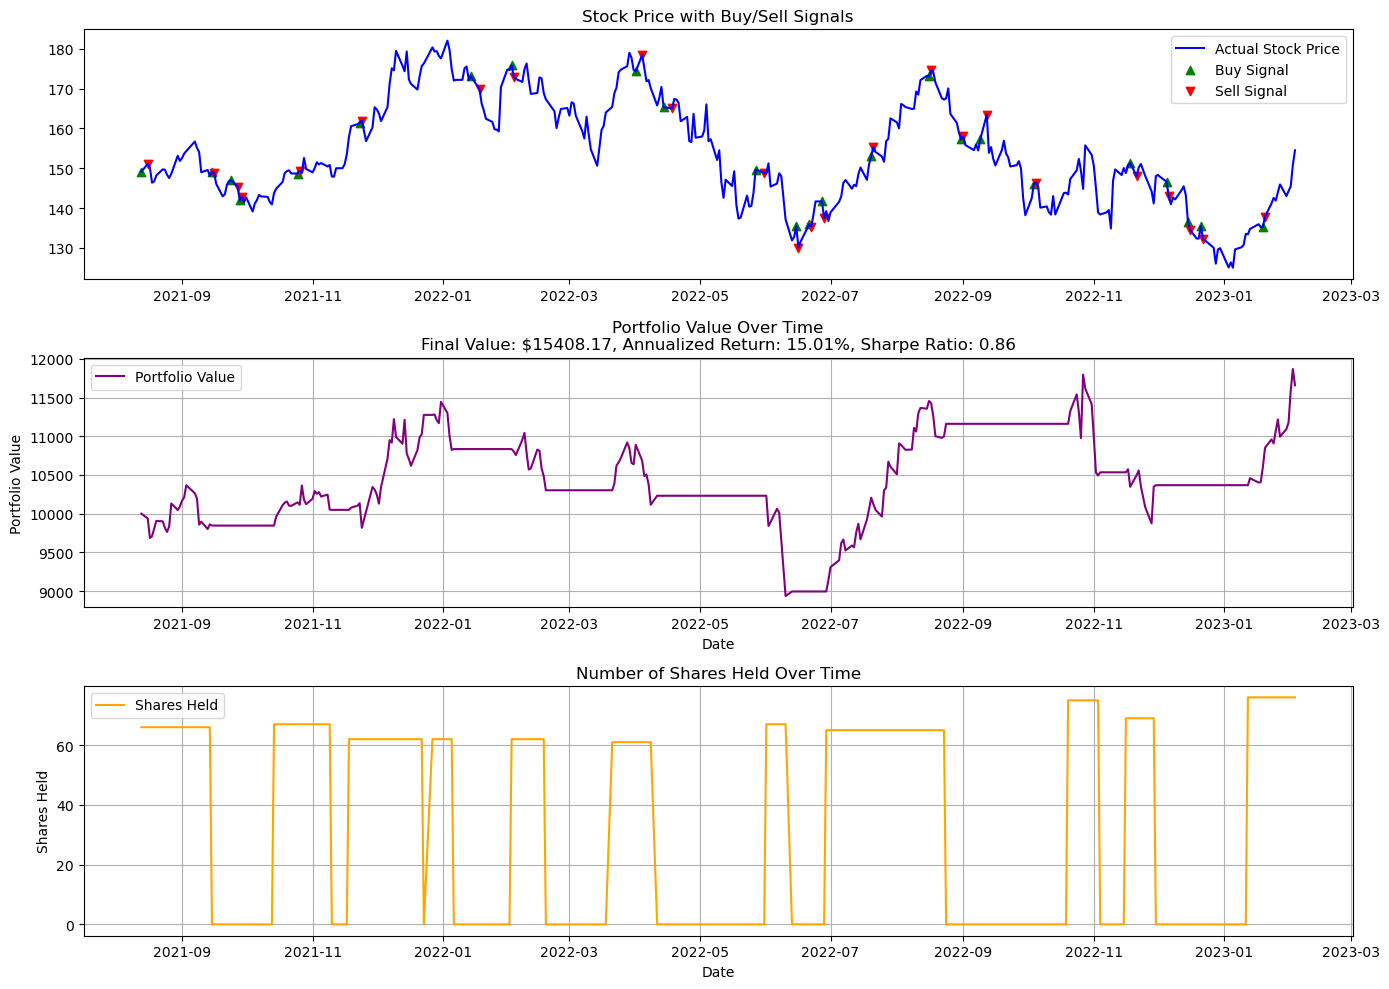

In [81]:
initial_investment = 10000  # Define the initial investment amount
# Use actual and predicted test data (y_test_actual and test_predict)
# We also pass the corresponding test dates using test_predict_range or similar
test_predict_range = data.index[train_size + time_step:train_size + time_step + len(test_predict)]
trading_env = MockTradingEnvironment(
    initial_investment=initial_investment, 
    stock_data=y_test_actual.flatten(), 
    predicted_prices=test_predict.flatten(),
    dates=test_predict_range  # Pass the correct date range for test data
)

# Perform trading based on predictions
trading_env.trade()

# Print all transactions
trading_env.print_transactions()

# Plot the results (portfolio value, buy/sell signals, and shares held)
trading_env.plot_results()